In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import fitsio
from astropy.table import Table, hstack

from desispec.io import read_spectra

# set global plotting variables
sns.set(style='white', context='paper', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [36]:
datadir = '/global/cfs/cdirs/desi/users/nrfran/speclens/' # NOTE: DELETE THE "OLD" once new outputs exist

lensCoadd = os.path.join(datadir, 'coadd-lenses.fits')
sourceCoadd = os.path.join(datadir, 'coadd-source.fits')
lensFastSpecFile = os.path.join(datadir, 'fastspec-lenses.fits')
rrLensFile = os.path.join(datadir, 'redrock-lenses.fits')
rrSourceFile = os.path.join(datadir, 'redrock-source.fits')
masterlensFile = os.path.join(datadir, 'masterlens-matches.fits')

rrSource = Table(fitsio.read(rrSourceFile))

I = np.where((rrSource['ZWARN'] == 0) * (rrSource['DELTACHI2'] > 40))[0]

rrSource = rrSource[I]

rrLens = Table(fitsio.read(rrLensFile))[I]

masterlens = Table(fitsio.read(masterlensFile))[I]

lensSpec = read_spectra(lensCoadd)
sourceSpec = read_spectra(sourceCoadd)

INFO:spectra.py:291:read_spectra: iotime 2.638 sec to read coadd-lenses.fits at 2023-03-30T11:42:39.326648
INFO:spectra.py:291:read_spectra: iotime 1.726 sec to read coadd-source.fits at 2023-03-30T11:42:42.841266


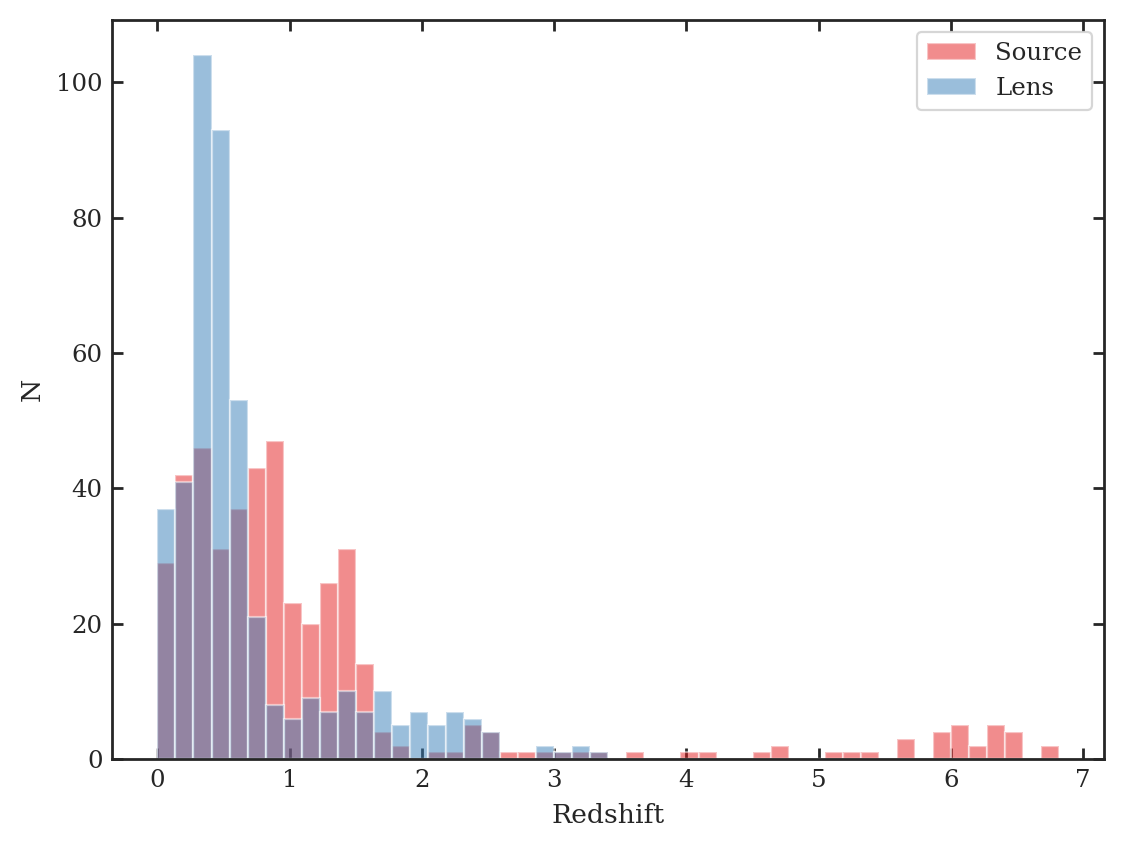

In [3]:
# histogram all the lens redshifts and source redshifts

fig, ax =  plt.subplots()

b = 50
a = 0.5

# source redshifts
_, bins, _ = ax.hist(rrSource['Z'], bins=b, alpha=a, label='Source')

# lens redshifts
_, bins, _ = ax.hist(rrLens['Z'], bins=bins, alpha=a, label='Lens')

ax.set_ylabel('N')
ax.set_xlabel('Redshift')
ax.legend();

In [77]:
# Create table "z" of all important info for analysis

lensFlux = {'b': lensSpec.flux['b'][I],
            'r': lensSpec.flux['r'][I],
            'z': lensSpec.flux['z'][I]}
sourceFlux = sourceSpec.flux['brz'][I]

lensWave = lensSpec.wave
sourceWave = sourceSpec.wave

z = hstack([masterlens, rrSource, rrLens])
z['Z_SOURCE'] = z['Z_SOURCE'].astype(float)
z['SOURCE_FLUX'] = sourceFlux
z['LENS_FLUX_B'] = lensFlux['b']
z['LENS_FLUX_R'] = lensFlux['r']
z['LENS_FLUX_Z'] = lensFlux['z']

z = z[~np.isnan(np.array(z['Z_SOURCE']))]

print(f'{len(z)}/{len(rrSource)} objects have lens redshifts in masterlens')

213/446 objects have lens redshifts in masterlens


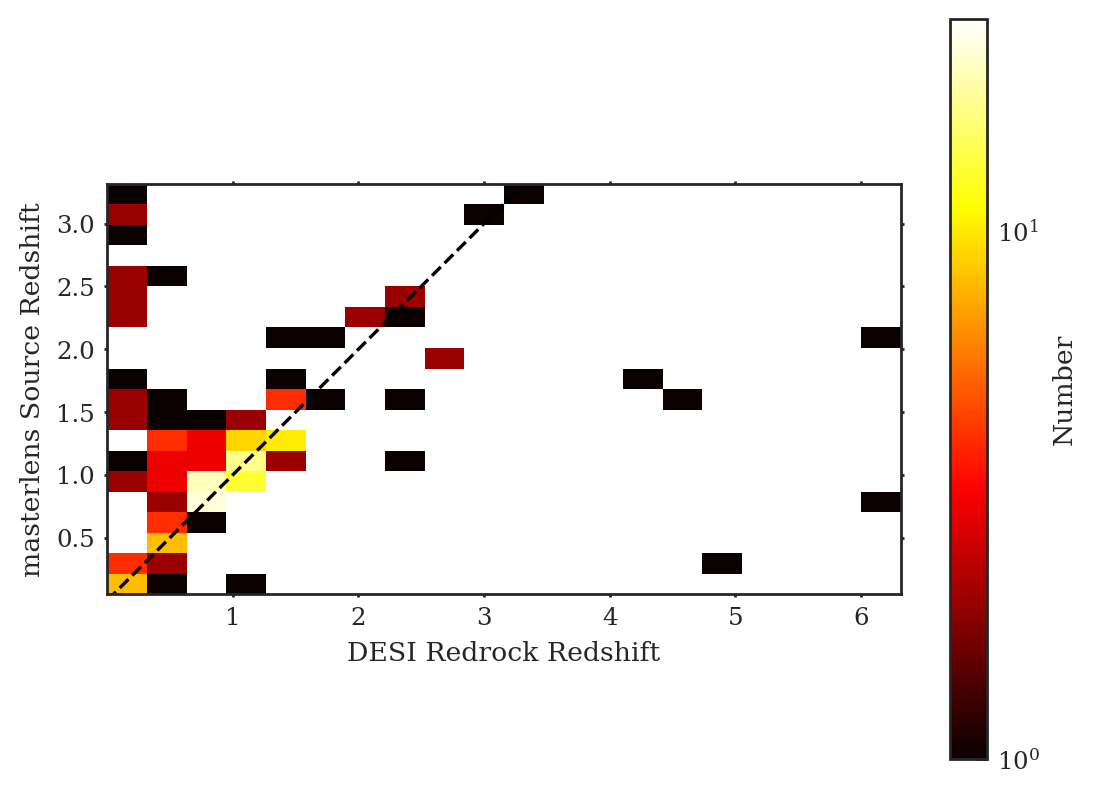

In [78]:
# compare accepted source redshift to our computed source redshift

fig, ax = plt.subplots()
#ax.plot(z['Z'], z['Z_LENS'], '.')
count, xedge, yedge, im = ax.hist2d(z['Z_2'], z['Z_SOURCE'],
                                    bins=20,
                                    cmap='hot',
                                    norm=LogNorm())
ax.set_ylabel('masterlens Source Redshift')
ax.set_xlabel('DESI Redrock Redshift')

xy = np.linspace(np.min(z['Z_2']), np.max(z['Z_2']))
ax.plot(xy, xy, 'k--')

ax.set_aspect('equal')
ax.tick_params(axis='both',
               which='major',
               direction='out',
               length=1)
fig.colorbar(im, label='Number')
fig.savefig('redshift-comparison-2dhist.png',
            bbox_inches='tight',
            transparent=False)

In [80]:
dz = 1e-5 # minimum difference between redrock source Z and masterlens source Z

whereMatch = np.where(np.abs(z['Z_2'] - z['Z_SOURCE']) < dz)[0]

goodZ = z[whereMatch]

print(goodZ)

  SYSTEM_NAME   DISCOVERY_DATE ...               LENS_FLUX_Z              
--------------- -------------- ... ---------------------------------------
     J1043+0444             "" ... 5.846475124359131 .. 4.9648661613464355
SDSS J1228+3743   "2011-11-00" ...     35.6826171875 .. 50.114112854003906


In [81]:
# function for plotting combined and source flux

def plotSpectra(t, sourceWave, lensWave):
    '''
    t [astropy.table.Table] : must include columns with flux of source and lens
    '''
    
    fig, ax = plt.subplots(1,1)
    
    for key in lensWave.keys():
        ax.plot(lensWave[key], t[f'LENS_FLUX_{key.upper()}'])
        
    ax.plot(sourceWave['brz'], t['SOURCE_FLUX'], 'k')
    
    ax.set_ylabel(r'F$_{\lambda}$ [10^{-17} erg s^{-1} cm^{-2} $\AA^{-1}$]')
    ax.set_xlabel(r'Wavelength [\AA]')
    ax.set_title(f"TARGETID: {t['TARGETID_2']}")

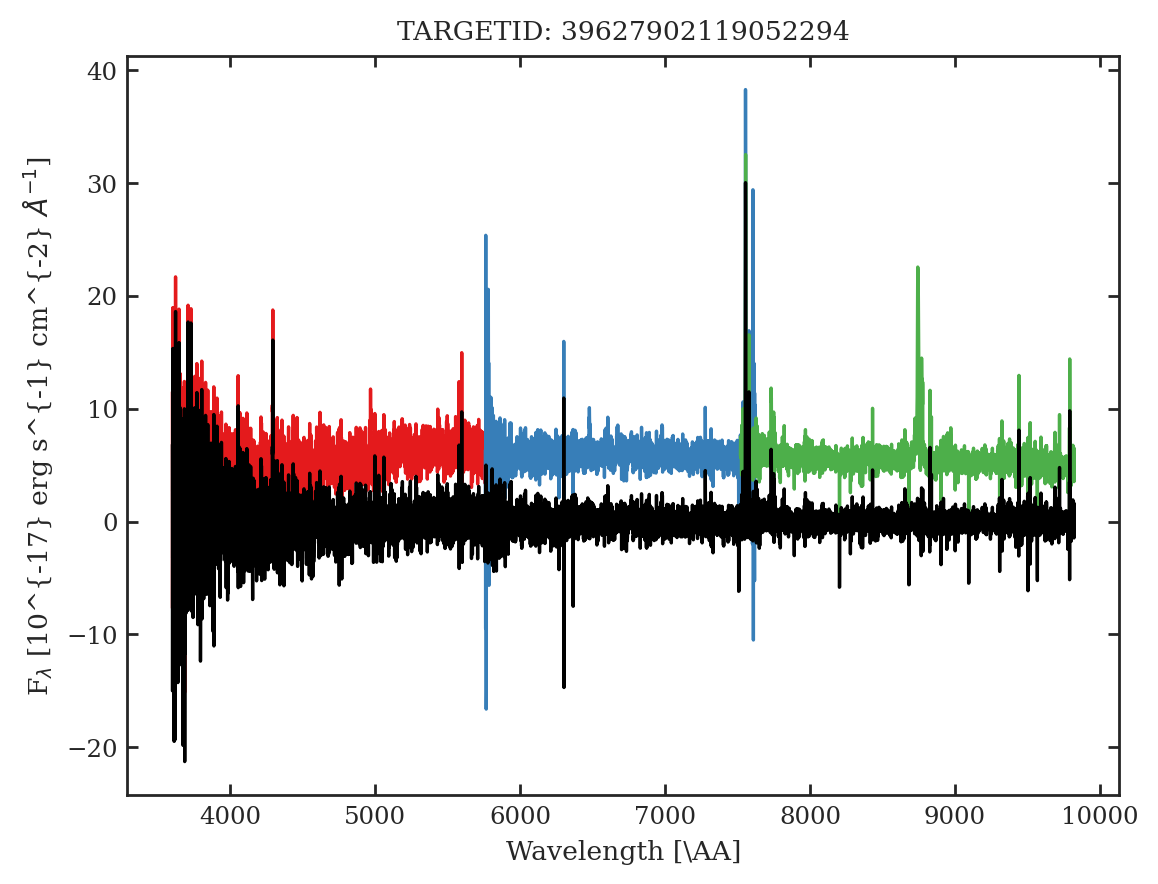

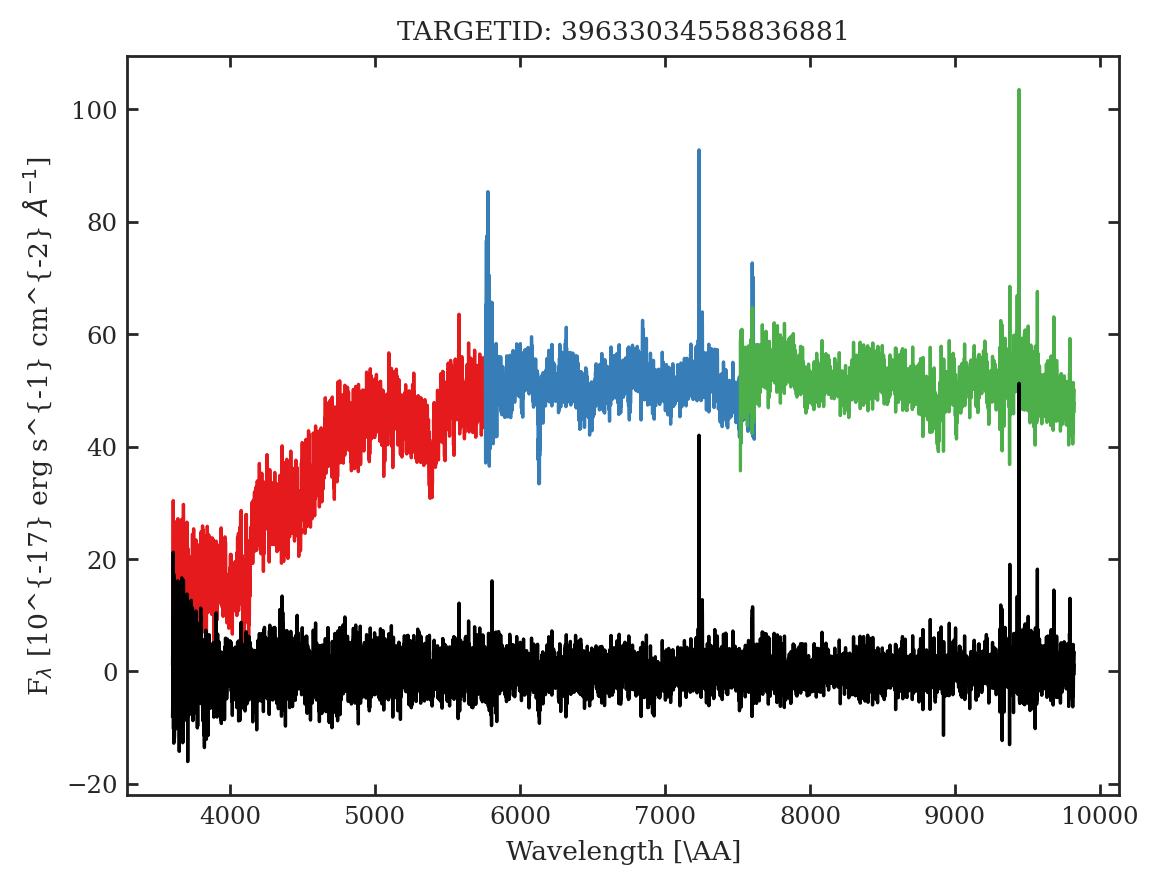

In [82]:
for ii in range(len(goodZ)):
    plotSpectra(goodZ[ii], sourceWave, lensWave)

In [96]:
goodSys = goodZ[1]

info = f'''
        Information about DESI Target {goodSys['TARGETID_2']}:\n
        Discoverer: {goodSys['DISCOVERY_ACRONYM']}
        Einstein Radius: {goodSys['THETA_E']}\n
        masterlens lens redshift: {goodSys['Z_LENS']}
        redrock lens redshift: {goodSys['Z_3']}\n
        masterlens source redshift: {goodSys['Z_SOURCE']}
        redrock source redshift: {goodSys['Z_2']}\n
       '''
print(info)


        Information about DESI Target 39633034558836881:

        Discoverer:  "SWELLS"
        Einstein Radius:  NaN

        masterlens lens redshift:  0.03993
        redrock lens redshift: 0.03993625657581866

        masterlens source redshift: 0.102
        redrock source redshift: 0.10200409054170041

       


In [ ]:
from astroquery.esa.hubble import ESA